# Crashlytics

In this notebook we investigate [US Car Accident Data](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents). 

Our goal is to create a classifier that can predict the severity of a car crash given the other features in the dataset. We will use three methods of classification (Decision Trees, XGBoost, and a Neural Network) and compare the results.

In [1]:
try:
    import pyspark
except ModuleNotFoundError:
    !pip3 install pyspark
    import pyspark
try:
    import pandas as pd
except ModuleNotFoundError:
    !pip3 install pandas
    import pandas as pd
    import csv
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    !pip3 install matplotlib
    import matplotlib.pyplot as plt

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, IndexToString, PCA, StandardScaler, Tokenizer, Word2Vec
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


In [5]:
#May need to install java for this to work
ss=SparkSession.builder.master("local").appName("crashlytics").getOrCreate()

In [6]:
rawDf = ss.read.csv("reduced_crash_data.csv", header=True, inferSchema=True)

In [7]:
rawDf.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: string (nullable = true)
 |-- End_Lng: string (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

## Imbalance in Data

Crash severity of 2 or 3 is much more common than any other severity ranking, and crash durations (duration of impact on traffic) are recorded as 30 minutes the majority of the time. This shows that the data is imbalanced, which we will have to consider when building our classifier.

In [8]:
severityCount = rawDf.groupBy(F.col("Severity")).count()
severityCount.show()

timeDf = rawDf.withColumn("Duration", (F.col("End_Time").cast("long") - F.col("Start_Time").cast("long"))/60)
time_count = timeDf.groupBy(F.col("Duration")).count()
time_count.orderBy(F.col("count"), ascending=False).show()

timeDf.select(F.col("Duration"), F.col("Severity")).show()
extremeSeverities = timeDf.filter(F.col("Severity") != 3).filter(F.col("Severity") != 2)
extremeSeverities.show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1|    6|
|       3| 3941|
|       4|    6|
|       2| 6047|
+--------+-----+

+------------------+-----+
|          Duration|count|
+------------------+-----+
|              30.0| 2302|
|              75.0|  752|
|              45.0|  739|
|              60.0|  519|
|              90.0|  213|
|29.666666666666668|  161|
|29.716666666666665|  158|
|              29.7|  153|
|             29.65|  151|
|29.683333333333334|  138|
|29.733333333333334|  134|
|29.616666666666667|  128|
|29.633333333333333|  124|
|29.766666666666666|  124|
|             29.75|  118|
|              29.8|  115|
|29.783333333333335|  113|
|              29.6|  110|
|29.583333333333332|  107|
|29.566666666666666|  104|
+------------------+-----+
only showing top 20 rows

+--------+--------+
|Duration|Severity|
+--------+--------+
|   314.0|       3|
|    30.0|       2|
|    30.0|       2|
|    30.0|       3|
|    30.0|       2|
|    30.0|       3|
|    30.0

23/11/30 11:30:29 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+-------+--------+-------------------+-------------------+---------+-----------+-------+-------+------------+--------------------+--------------------+-------------+-------------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+------------------+
|    ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|  Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|         City|       County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Am

## Clean data

The classifiers we plan to build cannot handle columns whose values are strings or "categorical" integers like Zipcode. So, we need to do something with them. 
 - For string columns describing categorical data (State, Daytime) we can turn them into indices. 
 - For string columns whose values we do not expect to be relevant to determining crash severity such as timezone, we can drop them from our dataset. 
 - For string columns that we cannot turn into indices but whose information may still be relevant, specifically weather and description, we can use Word2Vec, a neural-network based machine learning model that can turn strings to vectors while still retaining some semantic information.

After doing that processing, we still need to deal with records which have null values. For columns which have an obvious "neutral" stand-in value for null, we will replace all null values with that stand-in value. For columns that do not have an obvious stand-in value, we will have to drop those columns from the table to avoid drastically reducing the total record count.

### Convert categorical strings into indicees

In [9]:
labelIndexer = StringIndexer(inputCols = ["State", "Sunrise_Sunset"], outputCols = ["StateId", "DaytimeId"]).fit(rawDf)
indexedDf = labelIndexer.transform(timeDf)
#transformed_data.show(1)

### Drop irrelevant columns

In [10]:
indexAndTrimmedDf = indexedDf.drop("ID", "Airport_Code", "Zipcode", "Source", "Start_Time", "End_Time", "End_Lat", "End_Lng", "City", "County", "Zipcode", "Country", "Timezone", \
                         "Weather_Timestamp", "Wind_Direction", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight", "Turning_Loop", "State", "Street", "Sunrise_Sunset")


### Convert description and weather into vectors

This idea seemed really nice at first, but it increases the dimensionality of our data drastically and makes PCA far less effective. Without vectorizing these columns we need ~17 features to explain 95% of the variance in our data, with these vector columns we need >40.

In [11]:
increaseDimensionality = False

if increaseDimensionality:
    tokenizer_desc = Tokenizer(inputCol="Description", outputCol="desc_words")
    tokenizedDescDf = tokenizer_desc.transform(indexAndTrimmedDf)
    word2Vec_desc = Word2Vec(vectorSize=5, minCount=1, inputCol="desc_words", outputCol="desc_word2vec")
    model_desc = word2Vec_desc.fit(tokenizedDescDf)
    vectorizedDescriptionDf = model_desc.transform(tokenizedDescDf)

    tokenizer_weather = Tokenizer(inputCol="Weather_Condition", outputCol="weather_words")
    vectorizedDescriptionDf = vectorizedDescriptionDf.fillna({"Weather_Condition": ""})
    tokenizedWeatherDf = tokenizer_weather.transform(vectorizedDescriptionDf)
    word2Vec_weather = Word2Vec(vectorSize=3, minCount=1, inputCol="weather_words", outputCol="weather_word2vec")
    model_weather = word2Vec_weather.fit(tokenizedWeatherDf)
    vectorizedWeatherDf = model_weather.transform(tokenizedWeatherDf)

    #wordVecData_weather.select("Description", "desc_word2vec", "Weather_Condition", "weather_word2vec").show(420,truncate=False)

    cleanedDf = vectorizedWeatherDf.drop("Description", "Weather_Condition", "desc_words", "weather_words")

else:
    cleanedDf = indexAndTrimmedDf.drop("Description", "Weather_Condition")

### Handle null values

In [12]:
cleanedDf = cleanedDf.fillna({"Wind_Chill(F)": 0, "Precipitation(in)": 0, "Wind_Speed(mph)": 0})

## Vectorize our feature columns for use in K-Means clustering, PCA, and training our classifier(s). 

The rest of the processing we do on our data prefers our table be condensed into a single vectorized column, so we do that here.

In [13]:
columnNames = cleanedDf.columns
#Ignore reamining null values
assembler = VectorAssembler(inputCols=columnNames, outputCol="features", handleInvalid="skip")
vectorizedData = assembler.transform(cleanedDf)

lostRecordCount = cleanedDf.count() - vectorizedData.count()
print("Lost records due to null values: ", lostRecordCount) 
print("Fraction of total records lost: ", lostRecordCount/cleanedDf.count())

Lost records due to null values:  164
Fraction of total records lost:  0.0164


## K-Means Clustering

This data has a large number of features, so we will perform K-Means Clustering to see if we can find some patterns in our data and PCA to better understand which features of our dataset affect crash severity.

In [177]:
# Lets define a KMeans fit function since we'll be calling this multiple times
def fit_kmeans(df_input,num_cluster_centers=3):
  kmeans = KMeans().setK(num_cluster_centers).setSeed(1)
  
  model = kmeans.fit(df_input)
  
  clustered_data = model.transform(df_input)

  wcss = model.summary.trainingCost
  
  return clustered_data, wcss

In [178]:
kValues = range(2, 20)
wcss_scores = []

for k in kValues:
  clustered_data, wcss = fit_kmeans(vectorizedData,num_cluster_centers=k)
  wcss_scores.append(wcss)

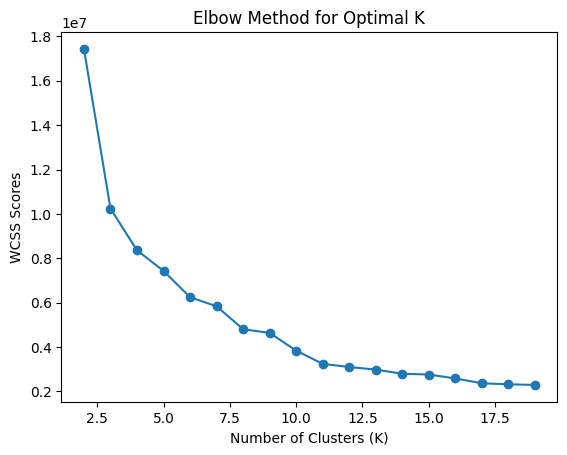

In [179]:
plt.plot(kValues, wcss_scores, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS Scores")
plt.show()

## Result of K-Means

After performing K-Means clustering with 2-20 clusters, there is no obvious candidate for optimal number of clusters. This could indicate that our data does not have well-separated, distinct clusters. Reducing the dimensionality of our data may lead to better results, so after completing PCA and identifying the principle components of our dataset we will revisit K-Means.

## PCA

This data has a large number of features, so we will perform PCA to see what the true dimensionality of our data is, and see if we can produce better K-Means results after reducing our data

In [180]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(vectorizedData)
scaledData = scalerModel.transform(vectorizedData)

pca = PCA(k=26, inputCol="scaledFeatures", outputCol="pcaFeatures")
pcaModel = pca.fit(scaledData)
result = pcaModel.transform(scaledData)

print("Explained Variance: ", sum(pcaModel.explainedVariance))

'''
print(cleanedDf.columns)

originalFeatureNames = cleanedDf.columns
x = 0
y = 0
while x < 26:
    
    print(x)
    x += 1
    m = str(x)
    originalFeatureNames[y] = m
    y += 1


#eigenvalues = model.explainedVariance.values
#plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
#plt.xlabel('Principal Components')
#plt.ylabel('Explained Variance')
#plt.show()

loadings = pcaModel.pc.toArray()

first_pc_loadings = loadings[:, 0]
print(loadings)
top_contributing_features = [feature_name for feature_name, loading in zip(originalFeatureNames, first_pc_loadings)]

plt.plot(originalFeatureNames, first_pc_loadings)
plt.xlabel('Original Features')
plt.ylabel('Loadings')
plt.title('Loadings for the First Principal Component')
plt.show()
for i in range(0, len(first_pc_loadings)):
    print(first_pc_loadings[i])
    print(cleanedDf.columns[i])
'''

Explained Variance:  0.9999999999999998


"\nprint(cleanedDf.columns)\n\noriginalFeatureNames = cleanedDf.columns\nx = 0\ny = 0\nwhile x < 26:\n    \n    print(x)\n    x += 1\n    m = str(x)\n    originalFeatureNames[y] = m\n    y += 1\n\n\n#eigenvalues = model.explainedVariance.values\n#plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')\n#plt.xlabel('Principal Components')\n#plt.ylabel('Explained Variance')\n#plt.show()\n\nloadings = pcaModel.pc.toArray()\n\nfirst_pc_loadings = loadings[:, 0]\nprint(loadings)\ntop_contributing_features = [feature_name for feature_name, loading in zip(originalFeatureNames, first_pc_loadings)]\n\nplt.plot(originalFeatureNames, first_pc_loadings)\nplt.xlabel('Original Features')\nplt.ylabel('Loadings')\nplt.title('Loadings for the First Principal Component')\nplt.show()\nfor i in range(0, len(first_pc_loadings)):\n    print(first_pc_loadings[i])\n    print(cleanedDf.columns[i])\n"

### Finding ideal number of principle components

We will find the minimum number of principle components needed to explain at least 95% of the variance

In [181]:
principleComponents = range(1, 26)
bestPcCount = 1
for pc in principleComponents:
    pca=PCA(k=pc, inputCol="scaledFeatures", outputCol="pcaFeatures")
    pcaModel = pca.fit(scaledData)
    if sum(pcaModel.explainedVariance) > 0.95:
        bestPcCount = pc
        break
bestPca = PCA(k=bestPcCount, inputCol="scaledFeatures", outputCol="pcaFeatures")
bestPcaModel = bestPca.fit(scaledData)
pcaReducedDf = bestPcaModel.transform(scaledData)

print("Princple Components needed for >95% explained variance: ", bestPcCount)
print("Explained Variance: ", sum(bestPcaModel.explainedVariance))

Princple Components needed for >95% explained variance:  21
Explained Variance:  0.9576496001031898


In [182]:
def fit_kmeans_column(df_input,column_name='pcaFeatures',num_cluster_centers=3):
  kmeans = KMeans(featuresCol=column_name).setK(num_cluster_centers).setSeed(1)
  
  model = kmeans.fit(df_input)
  
  clustered_data = model.transform(df_input)

  wcss = model.summary.trainingCost
  
  return clustered_data, wcss

In [183]:
wcss_scores_pca = []

for k in kValues:
  clustered_data, wcss = fit_kmeans_column(pcaReducedDf,column_name="pcaFeatures",num_cluster_centers=k)
  wcss_scores_pca.append(wcss)

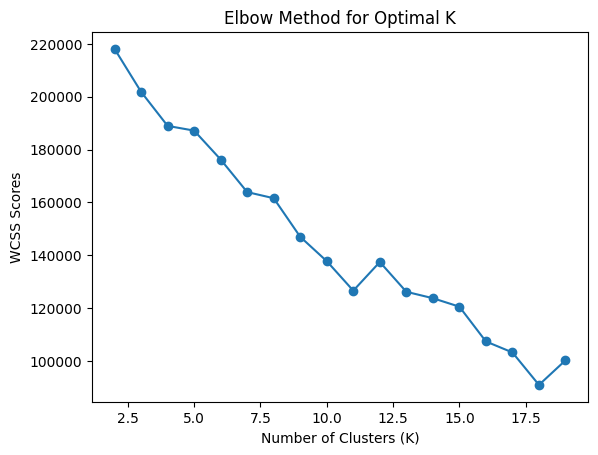

In [184]:
plt.plot(kValues, wcss_scores_pca, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS Scores")
plt.show()

## Result of PCA

Unfortunately the results of K-Means clustering are still inconclusive after performing PCA and extracting the principle components of our dataset. Moreover, we were not able to greatly reduce the dimensionality of our data by performing PCA, in order to explain 95% of the variance in our data we needed to retain 21 principle components from 26 features.

## Decision Tree Classifier

Before beginning training we need to remove the Severity column from the features column, as the classifier will be predicting the severity.

In [16]:
columnNames = cleanedDf.drop("Severity").columns
#Some columns can still have null values so we ignore them when generating our vectorized column for use by the classifier
assembler = VectorAssembler(inputCols=columnNames, outputCol="features", handleInvalid="skip")
classifierData = assembler.transform(cleanedDf)

Create a Decision tree classifier using arbitrary hyperparameters

In [17]:
trainingData, testData = classifierData.randomSplit([0.75, 0.25], seed=42)

dtClassifier = DecisionTreeClassifier(featuresCol="features", labelCol="Severity", maxDepth=6, minInstancesPerNode=2, maxBins=32)
dtModel = dtClassifier.fit(trainingData)
validationPredictions = dtModel.transform(testData)

accuracyEvaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
accuracy = accuracyEvaluator.evaluate(validationPredictions)
print(f"Accuracy: {accuracy}")

f1Evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="f1")
f1 = f1Evaluator.evaluate(validationPredictions)
print(f"F1: {f1}")

Accuracy: 0.7663590604026845
F1: 0.7679854143668958


### Hyperparameter tuning for Decision Tree Classifier

We perform hyperparameter tuning on the classifier to identify the best set of hyperparameters.

In [187]:
hyperparamsEvaluationDf = pd.DataFrame(columns = ["max_depth", "minInstancesPerNode", "training f1", "validation f1", "training accuracy", "validation accuracy", "Best Model"])

index = 0
bestIndex = 0
highestTestF1 = 0
bestDtModel = None

maxDepthList = range(2, 19)
minInstancesPerNodeList = range(2,15)
trainingData.persist()
testData.persist()

for maxDepth in maxDepthList:
    for minInstances in minInstancesPerNodeList:
        seed = 42
        dtClassifier = DecisionTreeClassifier(featuresCol="features", labelCol="Severity", maxDepth=maxDepth, minInstancesPerNode=minInstances)
        dtModel = dtClassifier.fit(trainingData)
        trainingPredictions = dtModel.transform(trainingData)
        validationPredictions = dtModel.transform(testData)
        trainingF1 = f1Evaluator.evaluate(trainingPredictions)
        validationF1 = f1Evaluator.evaluate(validationPredictions)
        trainingAccuracy = accuracyEvaluator.evaluate(trainingPredictions)
        validationAccuracy = accuracyEvaluator.evaluate(validationPredictions)

        hyperparamsEvaluationDf.loc[index] = [maxDepth, minInstances, trainingF1, validationF1, trainingAccuracy, validationAccuracy, 0]

        if validationF1 > highestTestF1:
            highestTestF1 = validationF1
            bestIndex = index
            bestDtModel = dtModel

        index += 1

print(hyperparamsEvaluationDf.loc[bestIndex])

max_depth              15.000000
minInstancesPerNode     5.000000
training f1             0.911692
validation f1           0.848039
training accuracy       0.912104
validation accuracy     0.848574
Best Model              0.000000
Name: 172, dtype: float64


### Results of classification with a decision tree

Our classifier achieved an f1 score on validation data of 0.85 with 85% accuracy. Let's visualize our decision tree to see if we can better understand how it is making its predictions.

In [188]:
from decision_tree_plot.decision_tree_parser import decision_tree_parse
try:
    from decision_tree_plot.decision_tree_plot import plot_trees
except ModuleNotFoundError:
    !pip3 install jinja2
    from decision_tree_plot.decision_tree_plot import plot_trees

In [189]:
bestModelPath = "bestDecisionTreeModel"
bestTree = decision_tree_parse(bestDtModel, ss, bestModelPath)
column = dict([(str(idx), i) for idx, i in enumerate(columnNames)])
plot_trees(bestTree, column = column, output_path = 'decisionTreeVisualization.html')

### Decision tree visualization

The visualization of the decision tree is dense and hard to decipher. Later we will see how many features we need to keep to achieve similar amounts of predictive ability, and the visualization should be easier to understand if that succeeds.

## Classification with XGBoost

We want to try classification using an XGBoost model, but PySpark does not have a native one. So, we use the XGBoost model provided by scikit-learn and use Fugue to allow training and testing the model with PySpark.

In [18]:
try: 
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, f1_score
    from sklearn.preprocessing import LabelEncoder
except:
    !pip3 install scikit-learn
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, f1_score
    from sklearn.preprocessing import LabelEncoder
try:
    from xgboost import XGBClassifier
    from xgboost.spark import SparkXGBClassifier
except ModuleNotFoundError:
    !pip3 install xgboost
    from xgboost import XGBClassifier
    from xgboost.spark import SparkXGBClassifier


In [25]:
#indexer = StringIndexer(inputCol="Severity", outputCol="IndexedSeverity")
#indexedClassifierData = indexer.fit(classifierData).transform(classifierData)
xgbData = classifierData.toPandas()

stringIndex = StringIndexer(inputCol="Severity", outputCol="IndexedSeverity")
fitted = stringIndex.fit(classifierData)
fittedData = fitted.transform(classifierData)

xgbClassifier = SparkXGBClassifier(features_col="features", label_col="IndexedSeverity")
xgbModel = xgbClassifier.fit(fittedData)
predictions = xgbModel.transform(fittedData)


2023-11-30 11:37:26,639 INFO XGBoost-PySpark: _fit Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 4, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[11:37:28] task 0 got new rank 0                                    (0 + 1) / 1]
/Users/elliott/ds410-crashlytics/.venv/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
2023-11-30 11:37:30,041 INFO XGBoost-PySpark: _fit Finished xgboost training!   


In [4]:
#ss.stop()